In [5]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import wordcloud
import multidict
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

In [2]:
'''
spark = SparkSession.builder \
        .master("yarn") \
        .appName("HelloLines") \
        .getOrCreate()
sc = spark.sparkContext
rdd = sc.textFile("hdfs:/user/cunha/hello.txt")
'''
os.environ["JAVA_HOME"] = "/home/luizcouto/Apps/jdk-8"
os.environ["HADOOP_INSTALL"] = "/home/luizcouto/Apps/hadoop-2.7.3"
os.environ["HADOOP_HOME"] = os.environ["HADOOP_INSTALL"]
os.environ["HADOOP_MAPRED_HOME"] = os.environ["HADOOP_INSTALL"]
os.environ["HADOOP_COMMON_HOME"] = os.environ["HADOOP_INSTALL"]
os.environ["HADOOP_HDFS_HOME"] = os.environ["HADOOP_INSTALL"]
os.environ["HADOOP_YARN_HOME"] = os.environ["HADOOP_INSTALL"]
os.environ["HADOOP_CONF_DIR"] = os.path.join(os.environ["HADOOP_INSTALL"], "/etc/hadoop")

table_schema = StructType([
    StructField("hashtag", StringType(), True),
    StructField("popularity",   IntegerType(), True),
    StructField("correlated", StringType(), True),
])

spark = SparkSession \
    .builder \
    .enableHiveSupport() \
    .config(conf=SparkConf().set("spark.driver.maxResultSize", "2g")) \
    .appName("wordcloudmapp") \
    .getOrCreate()

path = "../../out/"
df = spark.read.csv(path, schema=table_schema)
df.show()




22/05/12 10:45:06 WARN Utils: Your hostname, luizcouto-X510URR resolves to a loopback address: 127.0.1.1; using 192.168.1.100 instead (on interface wlp2s0)
22/05/12 10:45:06 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/12 10:45:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+--------------------+----------+--------------------+
|             hashtag|popularity|          correlated|
+--------------------+----------+--------------------+
|                 #19|         1|#mentalwellness,#...|
|              #28Mar|         1|#VirgenMaría,#Cov...|
|#60AniversarioISSSTE|         1|#MéxicoUnido,#Qué...|
|#ActivadosPorLa-S...|         1|#QuédateEnCasa,#J...|
|#ActivadosPorLaSalud|         3|#QuédateEnCasa,#C...|
| #BandasSinApellidos|         1|#LaMúsicaEnseñaVa...|
| #BersamaLawanCorona|         1|#HidupSehattvOne,...|
|          #Bolsonaro|         1|#PandemiaCoronavi...|
|             #Brasil|         1|                null|
|            #COVID19|        67|#Coronavirus,#COV...|
|   #COVID19Indonesia|         1|#HidupSehattvOne,...|
|   #COVID19argentina|         1|#blogdeviajes,#ar...|
|          #COVID19😷|         1|         #OpiniónLSR|
|          #COVID19🦠|         1|#MéxicoUnido,#Qué...|
|          #COVID2019|         1|            #COVID19|
|           

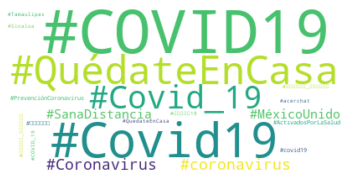

In [3]:
ordered = df.orderBy("popularity", ascending=False)
ordered = ordered.limit(50)

word_cloud_dict = multidict.MultiDict()
data_collect = ordered.rdd.toLocalIterator()
for row in data_collect:
    word_cloud_dict.add(str(row.hashtag), math.log2(int(row.popularity)))


wc = wordcloud.WordCloud(background_color="white", max_words=500)
wc.generate_from_frequencies(word_cloud_dict)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

/usr/lib/python3/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 129320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/lib/python3/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 129440 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/lib/python3/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3650 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/lib/python3/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/lib/python3/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3623 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/lib/python3/dist-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 3636 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/lib/python3/dist-pa

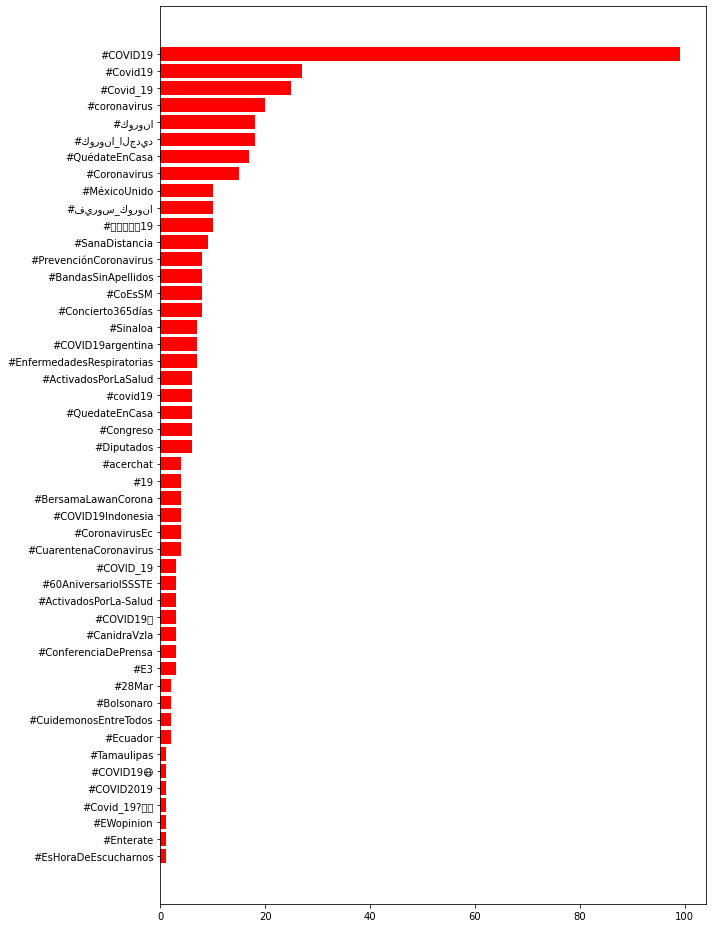

In [4]:
data_iter = ordered.rdd.toLocalIterator()
degrees_histogram = []
for row in data_iter:
    if row["correlated"] is not None:
        if len(row["correlated"]) > 0:
            val = row["correlated"].count(",") + 1
        
        degrees_histogram.append((row["hashtag"], val))


degrees_histogram.sort(key=lambda tup: tup[1], reverse=True)

small_histogram = [freq for (_, freq) in degrees_histogram[:50]][::-1]
names = [name for (name, _) in degrees_histogram[:50]][::-1]
indices = np.arange(len(small_histogram))
plt.figure(figsize=(10, 13))
plt.barh(indices, small_histogram, color='r', height=0.8)
plt.yticks(indices, names, rotation='horizontal')
plt.tight_layout()
plt.show()